# Introduction

In this part, a CNN is used to make financial time-series prediction. 
The input is a matrix of shape (30,5) which is the result of the pre-processing program. 
The problem is a supervised bi-label classification. Given the input matrix, the neural network returns two labels:
- Go up (the neural network forecasts that the price of the stock goes up for the next day)
- Go Down (the neural network forecasts that the price of the stock goes down for the next day)

Thanks to Rachnog (https://github.com/Rachnog/Deep-Trading) for this part which is inspired from its work. <br> 
Thanks to  Jason Brownlee (https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) for the training historic visualization in keras.<br><br>
This network's result serves as a baseline to compare with the results coming from the Capsules Network.

# Imports

In [1]:
from utils import *

import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle 
from tqdm import tqdm 
import os

/Users/Selim/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

- <b>WINDOW</b> is the number of previous observations taken to build the input matrix
- <b>EMB_SIZE</b> is the number of features (Open, High, Low, Close, Volume)
- <b>FORECAST</b> is the delta-time in the future which is used for the labels (usually 1,2 or 3)

In [4]:
WINDOW = 30
EMB_SIZE = 5
FORECAST = 1

For all the ticker, we use the training and validation dataset in order to get the accuracy of the CNN. The validation accuracy is used as a metric because at this point, there is no hyper-parameters optimization. So, there is no over-fitting done by hyper-parameters optimization. 

# Model 

We put the Model into a function with the tickers as input to make it easier to train the Model with all the tickers. 

In [15]:

def cnn_model(ticker, visu = 'False'):
    """
    This function takes a tickers as input.
    It returns a dictionnary of different results coming from the CNN which has been trained with the tickers data.
    The architecture of the CNN is the same for all the tickers, there is no hyper-parameters optimization. 
    The CNN are trained with the same number of epochs.
    The dictionnary is composed of:
    - Ticker
    - Maximum training accuracy over the epochs
    - Epoch in which this maximum accuracy occured
    - Maximum validation accuracy over the epochs
    - Epoch in which this maximum accuracy occured
    
    
    visu is an argument which enables visualization of the training history if requiered
    """

    #load the input matrices corresponding to the ticker
    path = "./data_out_autoreg/{}/".format(ticker)
    x_train = np.load(path+'X_train.npy')
    shape_x_train = x_train.shape
    x_val = np.load(path+'X_val.npy')
    y_train = np.load(path+'Y_train.npy')
    y_val = np.load(path+'Y_val.npy')
    
    #reshape of the input matrix
    X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], EMB_SIZE))
    X_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], EMB_SIZE))
    
    #turn the label into a categorical matrix
    Y_train = np.eye(2)[y_train]
    Y_val = np.eye(2)[y_val]
    
    #construction of the model 
    model = Sequential()
    model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                            nb_filter=16,
                            filter_length=4,
                            border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    model.add(Convolution1D(nb_filter=8,
                            filter_length=4,
                            border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dense(2))
    model.add(Activation('softmax'))

    #otimization
    opt = Nadam(lr=0.002)
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=0)

    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #training
    history = model.fit(X_train, Y_train, 
              nb_epoch = 50, 
              batch_size = 128, 
              verbose=0, 
              validation_data=(X_val, Y_val),
              callbacks=[reduce_lr],
              shuffle=True)
    
    #this visualization if made only for the Apple ticker
    if visu == True:
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy {}'.format(ticker))
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss {}'.format(ticker))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
    #testing
    pred = model.predict(np.array(X_val))
    list_train_acc = history.history['acc']
    max_train_acc = max(list_train_acc)
    index_max_train_acc = list_train_acc.index(max_train_acc)
        
    list_val_acc = history.history['val_acc']
    max_val_acc = max(list_val_acc)
    index_max_val_acc = list_val_acc.index(max_val_acc)
        
    return {'ticker':ticker, 'max_train_accuracy':max_train_acc, 'epoch_max_train':index_max_train_acc,
           'max_val_accuracy':max_val_acc, 'epoch_max_val':index_max_val_acc}



# Example with Amazon 

/Users/Selim/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(30, 5), filters=16, kernel_size=4, padding="same")`
/Users/Selim/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, padding="same")`
/Users/Selim/anaconda/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


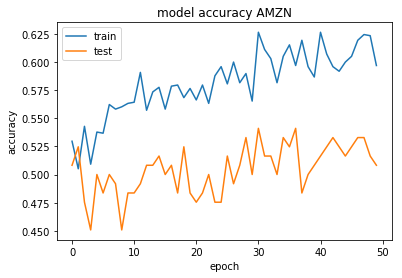

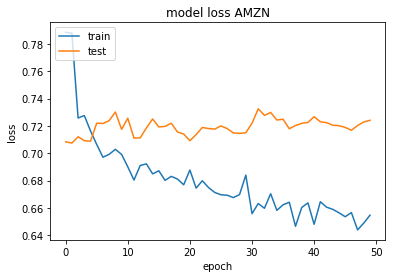

{'epoch_max_train': 30,
 'epoch_max_val': 30,
 'max_train_accuracy': 0.6262729149729074,
 'max_val_accuracy': 0.5409836173057556,
 'ticker': 'AMZN'}

In [18]:
cnn_model('AMZN', visu = True)

# Execution for all tickers and save of results

In [4]:
#save the results 

data_dir = './data_out_autoreg/'
directory = data_dir # path to the files
list_tickers  = os.listdir(directory) #these are the differents files
list_results = list()

for ticker in tqdm(list_tickers):
    list_results.append(cnn_model(ticker))
    
with open('list_results_selim_cnn.pkl', 'wb') as f:
    pickle.dump(list_results, f)    